# パーティクルフィルタによる自己位置推定

<IPython.core.display.Javascript object>


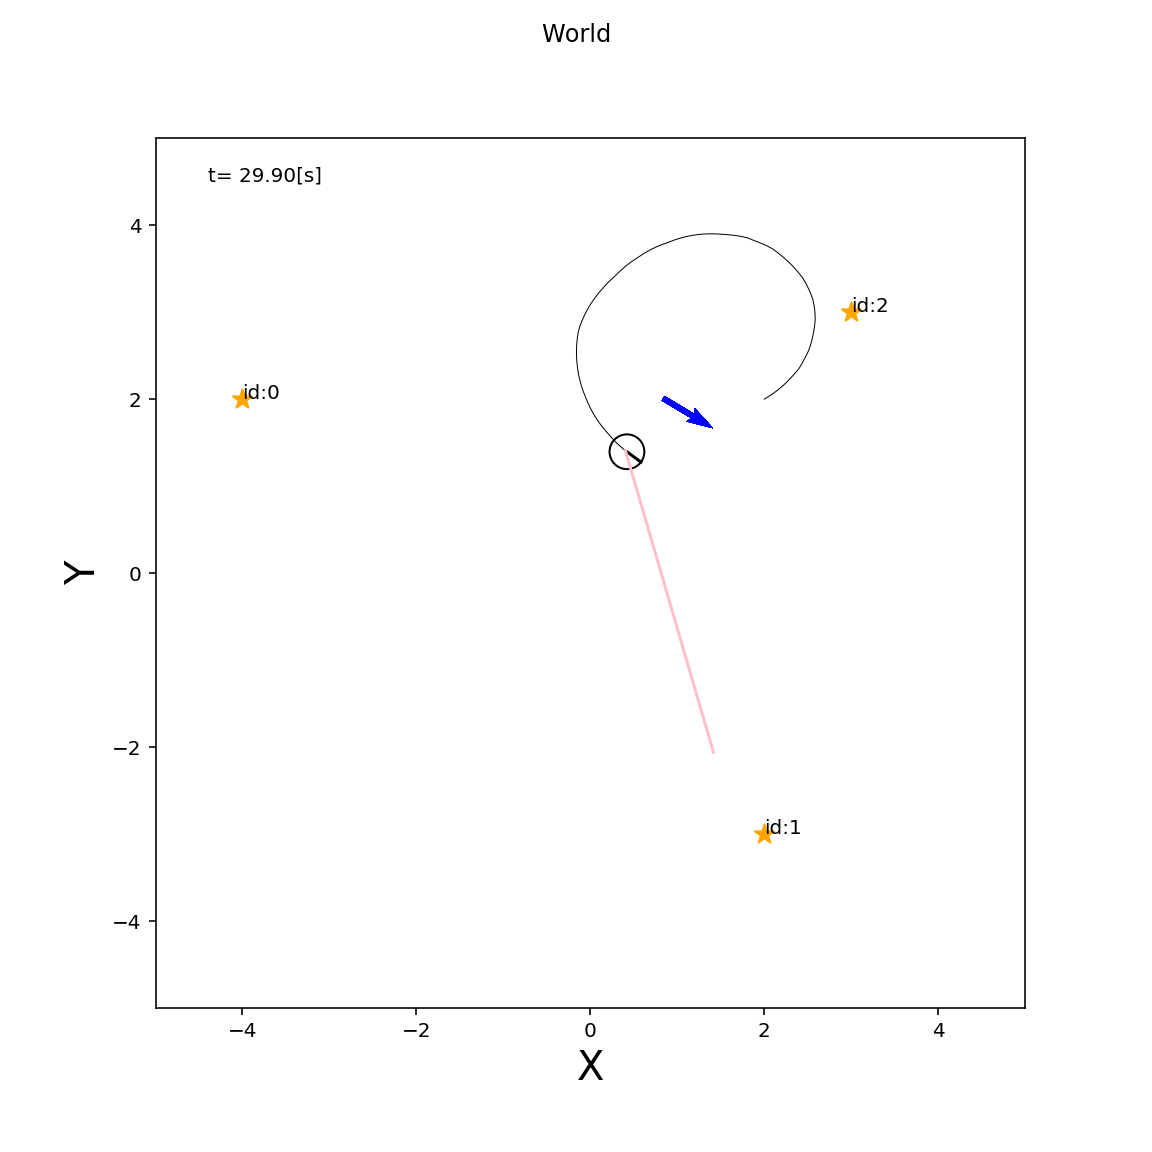

In [9]:
# 手始めにパーティクルを表示
import sys
sys.path.append('../src')
import importlib

import worlds
import maps
import numpy as np
import robots
import sensors
import agents
import landmarks
import estimators
import particles

def reload():
    importlib.reload(worlds)
    importlib.reload(maps)
    importlib.reload(robots)
    importlib.reload(sensors)
    importlib.reload(agents)
    importlib.reload(estimators)
    importlib.reload(particles)


reload()
    
world = worlds.World(30., 0.1, debuggable=False)
m = maps.Map()
for ln in [(-4., 2.), (2., -3), (3., 3.)]:
    m.append_landmark(landmarks.Point2DLandmark(*ln))
world.append(m)
    
initial_pose = np.array([2., 2., np.pi / 6.]).T
estimator = estimators.Mcl(
    initial_pose, 100,
    motion_noise_stds={'nn':0.00001, 'no': 0.00001, 'on': 0.00001, 'oo': 0.00001})
circling = agents.EstimationAgent(
    0.1, 0.2, 10./180.*np.pi, estimator=estimator)
r = robots.Robot(initial_pose, sensor=sensors.Camera(m), agent=circling)
world.append(r)
world.draw()

パーティクルの更新

状態遷移モデルを作ろう

シミュレータでロボットの挙動の統計をとって，作っていく

ノイズが正規分布に従うと仮定してみる

指数分布に従うノイズを入れたりしているが，まずはこれで

このときの雑音パラメータを

- $\sigma_{\nu \nu}$ : 直進1mで生じる道のりのばらつきのstddev
- $\sigma_{\nu \omega}$ : 回転1radで生じる道のりのばらつきのstddev
- $\sigma_{\omega \nu}$ : 直進1mで生じる回転のばらつきのstddev
- $\sigma_{\omega \omega}$ : 回転1radで生じる回転のばらつきのstddev

$\sigma_{a b}$は，$b$が$a$にあたえるばらつきのstddevを表す

$b$があたえる雑音$\delta_{ab}$は移動量・回転量に比例するので

$$
\delta^{2}_{ab} : \left(\delta^{\prime}_{ab} \Delta t \right)^{2} = 1 : |b| \Delta t \\
\\
\delta^{\prime}_{ab} = \delta_{ab} \sqrt{|b| / \Delta t}
$$

$a$, $b$に$\nu$, $\omega$を代入すると制御指令に加えるべき雑音がわかる

これを${\bf \it u}^{\prime}$とすると

$$
\left(
    \begin{array}{c}
        \nu^{\prime} \\
        \omega^{\prime}
    \end{array}
\right) = \left(
    \begin{array}{c}
        \nu^{\prime} \\
        \omega^{\prime}
    \end{array}
\right) + \left(
    \begin{array}{c}
        \delta_{\nu \nu} \sqrt{|\nu| / \Delta t} + \delta_{\omega \nu} \sqrt{|\omega|  / \Delta t} \\
        \delta_{\omega \nu} \sqrt{|\nu| / \Delta t} + \delta_{\omega \omega} \sqrt{|\omega|  / \Delta t}
\end{array}
\right)
$$

シミュレータでロボットを走らせて，これらの値を計測する

In [2]:
# 実装確認コード
reload()

init_pose = np.array([0., 0., 0.]).T
estimator = estimators.Mcl(
    init_pose, 100, 
    motion_noise_stds={'nn':0.01, 'no': 0.02, 'on': 0.03, 'oo': 0.04})
a = agents.EstimationAgent(0.1, 0.2, 10./180.*np.pi, estimator)
estimator.motion_update(0.2, 10./180.*np.pi, 0.1)
for p in estimator.particles:
    print(p.pose)

[1.66043874e-02 8.32504323e-05 1.00274382e-02]
[0.02075661 0.00023248 0.02239995]
[0.02127782 0.00032293 0.03035135]
[0.02513168 0.00025109 0.01998154]
[0.02074031 0.00011996 0.01156769]
[0.02160975 0.00015369 0.01422364]
[0.02239674 0.00015723 0.01404019]
[0.02022735 0.00010663 0.01054287]
[0.02341637 0.00036289 0.03099181]
[0.01919038 0.00014622 0.01523817]
[0.01560685 0.00014511 0.01859572]
[0.02184864 0.00013824 0.01265452]
[0.01902157 0.00010646 0.01119354]
[0.01510396 0.00015497 0.02051915]
[0.02081321 0.00019836 0.01906045]
[0.02305703 0.00013159 0.01141401]
[0.02244264 0.0002464  0.02195722]
[0.01771361 0.00015255 0.01722397]
[0.0182535  0.00015878 0.01739704]
[1.89801974e-02 9.05808957e-05 9.54470663e-03]
[0.01529439 0.00011093 0.01450626]
[0.01615158 0.00017335 0.02146466]
[0.01959581 0.00013847 0.01413285]
[0.021746   0.00025367 0.02332934]
[0.02417997 0.00024335 0.02012729]
[0.01913345 0.00020848 0.02179113]
[0.02115879 0.00011412 0.01078706]
[0.01943935 0.00025217 0.025942

<IPython.core.display.Javascript object>


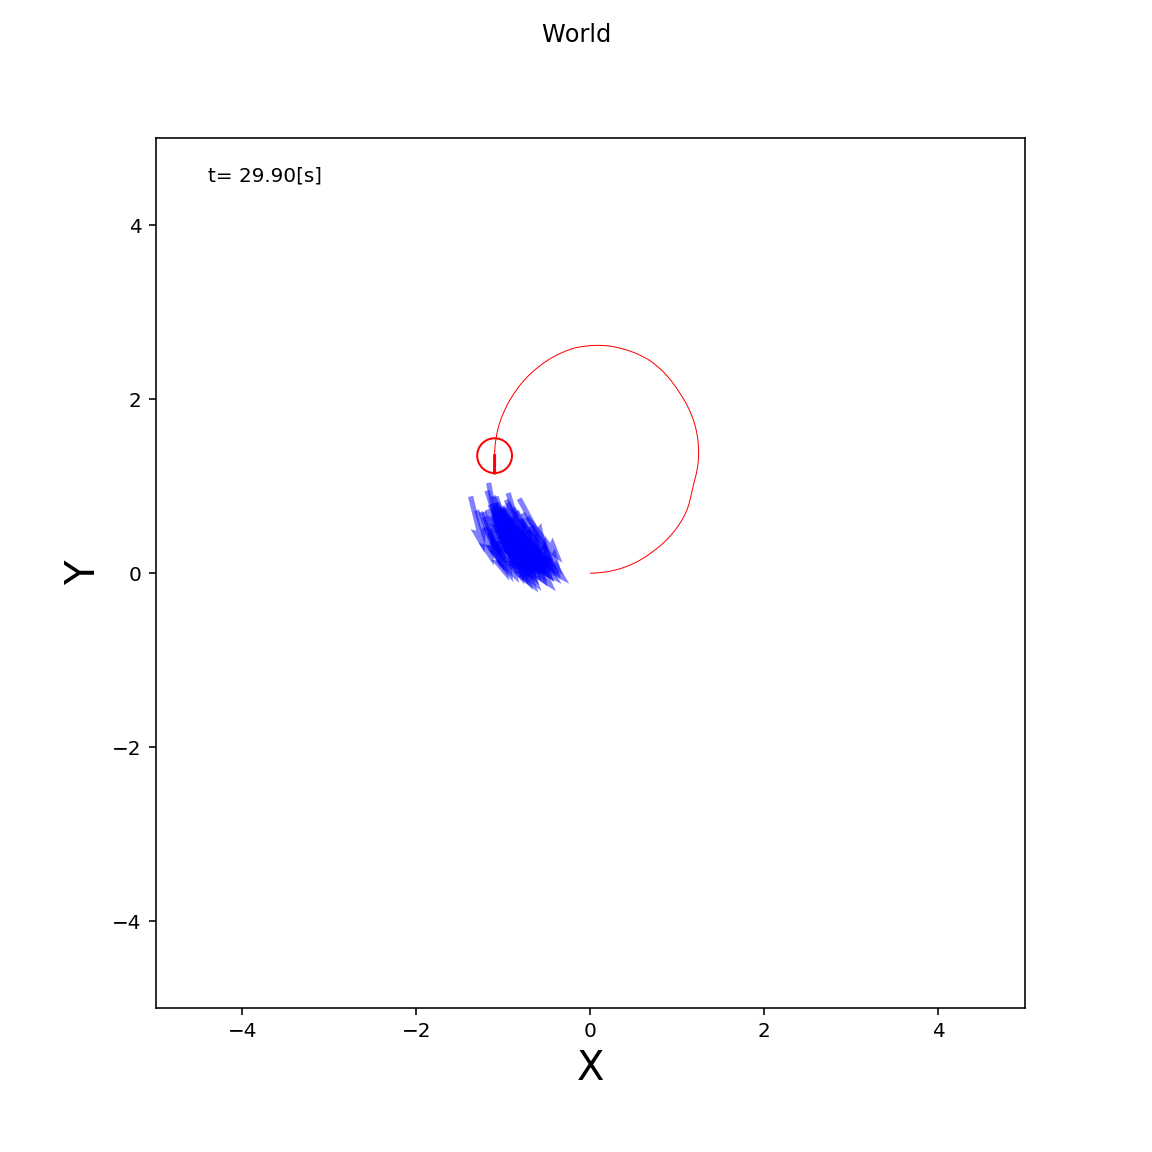

In [8]:
reload()
def trial(motion_noise_stds):
    time_interval = 0.1
    world = worlds.World(30., time_interval)
    
    initial_pose = np.array([0., 0., 0.]).T
    estimator = estimators.Mcl(initial_pose, 100, motion_noise_stds=motion_noise_stds)
    circling = agents.EstimationAgent(
        0.1, 0.2, 10./180.*np.pi, estimator=estimator)
    r = robots.Robot(initial_pose, sensor=None, agent=circling, color='red')
    world.append(r)
    
    world.draw()
    
trial({'nn':0.01, 'no': 0.02, 'on': 0.03, 'oo': 0.04})